In [1]:
import torch
from torch import nn
from torchvision import datasets,transforms,models

import matplotlib.pyplot as plt
from pathlib import Path
from helper_functions import download_data
from engine import train
from data_setup import create_dataloaders
from utils import save_model
import pandas as pd

2.6.0+cu124 False


/home/harish/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [3]:
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

data_20_percent_path

[INFO] data/pizza_steak_sushi_20_percent directory exists, skipping download.


PosixPath('data/pizza_steak_sushi_20_percent')

In [16]:
file_path = Path("data/pizza_steak_sushi_20_percent/")
train_dir = file_path / "train"
test_dir = file_path / "test"

In [5]:
def create_efficientnet_b2(num_classes=3):
    efficientnet_b2_weights = models.EfficientNet_B2_Weights.DEFAULT

    efficientnet_b2_transforms = efficientnet_b2_weights.transforms()

    efficientnet_b2 = models.efficientnet_b2(weights=efficientnet_b2_weights)

    for param in efficientnet_b2.parameters():
        param.requires_grad = False
    
    efficientnet_b2.classifier = nn.Sequential(
        nn.Dropout(p=0.3,inplace=True),
        nn.Linear(in_features=1408,out_features=3)
    )
    
    return efficientnet_b2,efficientnet_b2_transforms


In [6]:
effnetb2, effnetb2_transforms = create_efficientnet_b2(num_classes=3)


In [7]:
from torchinfo import summary

summary(effnetb2, 
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

In [8]:
train_dataloader_effnetb2,test_dataloader_effnetb2,class_names = create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=effnetb2_transforms,
    batch_size=32
)

In [9]:
class_names

['pizza', 'steak', 'sushi']

In [10]:
optimizer = torch.optim.Adam(
    params=effnetb2.parameters(),
    lr=1e-3
)
loss_fn = nn.CrossEntropyLoss()

effnetb2_results = train(
    model=effnetb2,
    optimizer=optimizer,
    loss_fn=loss_fn,
    train_dataloader=train_dataloader_effnetb2,
    test_dataloader=test_dataloader_effnetb2,
    epochs=10,
    device=device,
    writer=None
)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9326 | train_acc: 62.7083 | test_loss: 0.7188 | test_acc: 88.5227
Epoch: 2 | train_loss: 0.6965 | train_acc: 80.4167 | test_loss: 0.5886 | test_acc: 92.2727
Epoch: 3 | train_loss: 0.5900 | train_acc: 81.4583 | test_loss: 0.5065 | test_acc: 92.2727
Epoch: 4 | train_loss: 0.5144 | train_acc: 88.1250 | test_loss: 0.4330 | test_acc: 92.5568
Epoch: 5 | train_loss: 0.4301 | train_acc: 89.1667 | test_loss: 0.4109 | test_acc: 93.5227
Epoch: 6 | train_loss: 0.3830 | train_acc: 91.0417 | test_loss: 0.3626 | test_acc: 93.1818
Epoch: 7 | train_loss: 0.3861 | train_acc: 88.7500 | test_loss: 0.3447 | test_acc: 92.8977
Epoch: 8 | train_loss: 0.3091 | train_acc: 92.5000 | test_loss: 0.3108 | test_acc: 92.2727
Epoch: 9 | train_loss: 0.3541 | train_acc: 89.5833 | test_loss: 0.2938 | test_acc: 95.3409
Epoch: 10 | train_loss: 0.3487 | train_acc: 88.7500 | test_loss: 0.2855 | test_acc: 94.4318


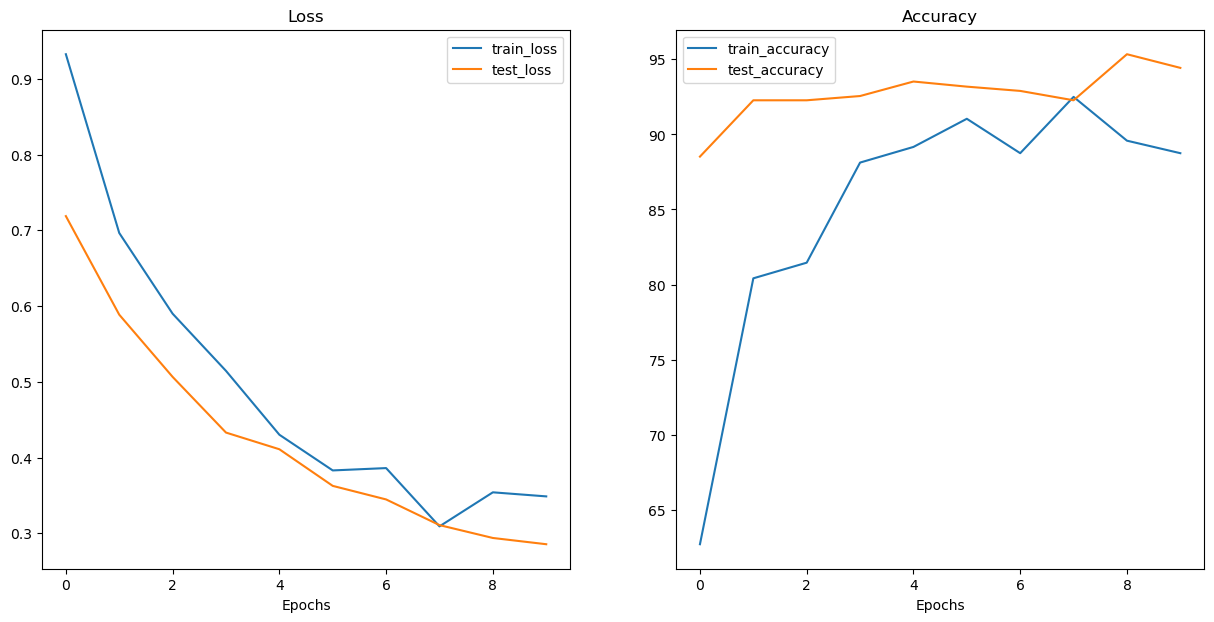

In [11]:
from helper_functions import plot_loss_curves

plot_loss_curves(effnetb2_results)

In [13]:
from utils import save_model

save_model(
    model=effnetb2,
    target_dir="models",
    model_name="effnetb2_pizza_steak_sushi.pt"
)

[INFO] Saving model to: models/effnetb2_pizza_steak_sushi.pt


In [14]:
effnetb2_model_size = round(Path("models/effnetb2_pizza_steak_sushi.pt").stat().st_size / (1024*1024),2) # Bytes(b)
print(f"EfficientNet_B2 model size: {effnetb2_model_size}Mb") # Bytes(b) -> MegaBytes(Mb)

EfficientNet_B2 model size: 29.83Mb


In [15]:
effnetb2_total_params = sum(torch.numel(param) for param in effnetb2.parameters())
effnetb2_total_params

7705221

In [16]:
effnetb2_stats = {
    "test_loss":effnetb2_results["test_loss"][-1],
    "test_acc":effnetb2_results["test_acc"][-1],
    "no_of_parameters": effnetb2_total_params,
    "model_size(Mb)":effnetb2_model_size
}
effnetb2_stats

{'test_loss': 0.2855386435985565,
 'test_acc': 94.43181818181817,
 'no_of_parameters': 7705221,
 'model_size(Mb)': 29.83}

In [17]:
models.vit_b_16(models.ViT_B_16_Weights.DEFAULT)

/home/harish/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [18]:
def create_vit(num_classes = 3):
    
    vit_weights = models.ViT_B_16_Weights.DEFAULT
    
    vit_transforms = vit_weights.transforms()
    
    model = models.vit_b_16(vit_weights)
    
    
    for params in model.parameters():
        params.requires_grad = False
        
    model.heads = nn.Sequential(
        nn.Linear(in_features=768,out_features=3)
    )
    
    return model,vit_transforms


In [19]:
vit,vit_transforms = create_vit()

In [20]:
train_dataloader_vit,test_dataloader_vit,class_names = create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=vit_transforms,
    batch_size=32
)
class_names

['pizza', 'steak', 'sushi']

In [21]:
optimizer = torch.optim.Adam(
    params=vit.parameters(),
    lr=1e-3
)

loss_fn = nn.CrossEntropyLoss()

vit_results = train(
    model=vit
    ,
    optimizer=optimizer,
    loss_fn=loss_fn,
    train_dataloader=train_dataloader_vit,
    test_dataloader=test_dataloader_vit,
    epochs=10,
    device=device,
    writer=None
)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6911 | train_acc: 74.1667 | test_loss: 0.2506 | test_acc: 96.2500
Epoch: 2 | train_loss: 0.2155 | train_acc: 95.0000 | test_loss: 0.1227 | test_acc: 98.1250
Epoch: 3 | train_loss: 0.1585 | train_acc: 95.8333 | test_loss: 0.0905 | test_acc: 98.7500
Epoch: 4 | train_loss: 0.1219 | train_acc: 96.4583 | test_loss: 0.0750 | test_acc: 98.1250
Epoch: 5 | train_loss: 0.1120 | train_acc: 97.0833 | test_loss: 0.0688 | test_acc: 98.7500
Epoch: 6 | train_loss: 0.0949 | train_acc: 97.7083 | test_loss: 0.0627 | test_acc: 99.3750
Epoch: 7 | train_loss: 0.0832 | train_acc: 97.9167 | test_loss: 0.0620 | test_acc: 99.3750
Epoch: 8 | train_loss: 0.0676 | train_acc: 98.5417 | test_loss: 0.0610 | test_acc: 99.3750
Epoch: 9 | train_loss: 0.0632 | train_acc: 99.1667 | test_loss: 0.0562 | test_acc: 99.3750
Epoch: 10 | train_loss: 0.0526 | train_acc: 99.3750 | test_loss: 0.0512 | test_acc: 99.3750


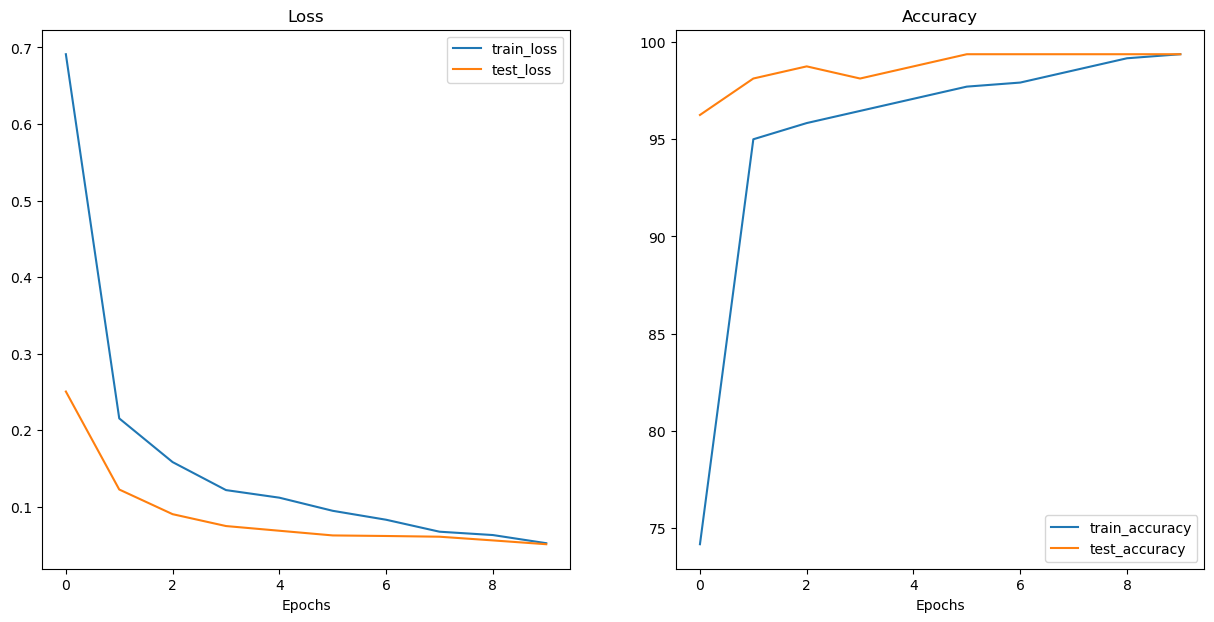

In [22]:
plot_loss_curves(vit_results)

In [23]:
save_model(
    model=vit,
    target_dir="models",
    model_name="vit_pizza_steak_sushi.pt"
)


[INFO] Saving model to: models/vit_pizza_steak_sushi.pt


In [24]:
vit_model_size = round(Path("models/vit_pizza_steak_sushi.pt").stat().st_size / (1024*1024),2) # Bytes(b) -> MegaBytes(Mb)
print(f"ViT model size: {effnetb2_model_size}Mb") 

ViT model size: 29.83Mb


In [25]:
vit_total_params = sum(torch.numel(param) for param in vit.parameters())
vit_total_params

85800963

In [26]:
vit_stats = {
    "test_loss":vit_results["test_loss"][-1],
    "test_acc":vit_results["test_acc"][-1],
    "no_of_parameters":vit_total_params,
    "model_size(Mb)":vit_model_size
}
vit_stats

{'test_loss': 0.05123566463589668,
 'test_acc': 99.375,
 'no_of_parameters': 85800963,
 'model_size(Mb)': 327.36}

In [27]:
df = pd.DataFrame([vit_stats,effnetb2_stats],index=["vit_stats","effnetb2_stats"])
df

,test_loss,test_acc,no_of_parameters,model_size(Mb)
vit_stats,0.051236,99.375000,85800963,327.36
effnetb2_stats,0.285539,94.431818,7705221,29.83


In [28]:
import pathlib

from PIL import Image
from timeit import default_timer as timer 
from tqdm.auto import tqdm
from typing import List, Dict

def pred_and_store(paths: List[pathlib.Path], 
                   model: torch.nn.Module,
                   transform: transforms, 
                   class_names: List[str], 
                   device: str = "cuda" if torch.cuda.is_available() else "cpu") -> List[Dict]:
    
    # 2. Create an empty list to store prediction dictionaries
    pred_list = []
    
    # 3. Loop through target paths
    for path in tqdm(paths):
        
        # 4. Create empty dictionary to store prediction information for each sample
        pred_dict = {}

        # 5. Get the sample path and ground truth class name
        pred_dict["image_path"] = path
        class_name = path.parent.stem
        pred_dict["class_name"] = class_name
        
        # 6. Start the prediction timer
        start_time = timer()
        
        # 7. Open image path
        img = Image.open(path)
        
        # 8. Transform the image, add batch dimension and put image on target device
        transformed_image = transform(img).unsqueeze(0).to(device) 
        
        # 9. Prepare model for inference by sending it to target device and turning on eval() mode
        model.to(device)
        model.eval()
        
        # 10. Get prediction probability, predicition label and prediction class
        with torch.inference_mode():
            pred_logit = model(transformed_image) # perform inference on target sample 
            pred_prob = torch.softmax(pred_logit, dim=1) # turn logits into prediction probabilities
            pred_label = torch.argmax(pred_prob, dim=1) # turn prediction probabilities into prediction label
            pred_class = class_names[pred_label.cpu()] # hardcode prediction class to be on CPU

            # 11. Make sure things in the dictionary are on CPU (required for inspecting predictions later on) 
            pred_dict["pred_prob"] = round(pred_prob.unsqueeze(0).max().cpu().item(), 4)
            pred_dict["pred_class"] = pred_class
            
            # 12. End the timer and calculate time per pred
            end_time = timer()
            pred_dict["time_for_pred"] = round(end_time-start_time, 4)

        # 13. Does the pred match the true label?
        pred_dict["correct"] = class_name == pred_class

        # 14. Add the dictionary to the list of preds
        pred_list.append(pred_dict)
    
    # 15. Return list of prediction dictionaries
    return pred_list

In [29]:
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_data_paths[:5]

[PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/2398925.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/44810.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/2250611.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/648055.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/998005.jpg')]

In [30]:
effnetb2_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                          model=effnetb2,
                                          transform=effnetb2_transforms,
                                          class_names=class_names,
                                          device="cpu")

  0%|          | 0/150 [00:00<?, ?it/s]

In [31]:
effnetb2_test_pred_dicts

[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/2398925.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.8893,
  'pred_class': 'pizza',
  'time_for_pred': 0.0779,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/44810.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.8022,
  'pred_class': 'pizza',
  'time_for_pred': 0.0462,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/2250611.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.8836,
  'pred_class': 'pizza',
  'time_for_pred': 0.0514,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/648055.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.841,
  'pred_class': 'pizza',
  'time_for_pred': 0.0495,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/998005.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.6828,
  'pred_class': 'pizza',
  'time_for_pred'

In [32]:
import pandas as pd
effnetb2_test_pred_df = pd.DataFrame(effnetb2_test_pred_dicts)
effnetb2_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi_20_percent/test/pizza/2...,pizza,0.8893,pizza,0.0779,True
1,data/pizza_steak_sushi_20_percent/test/pizza/4...,pizza,0.8022,pizza,0.0462,True
2,data/pizza_steak_sushi_20_percent/test/pizza/2...,pizza,0.8836,pizza,0.0514,True
3,data/pizza_steak_sushi_20_percent/test/pizza/6...,pizza,0.8410,pizza,0.0495,True
4,data/pizza_steak_sushi_20_percent/test/pizza/9...,pizza,0.6828,pizza,0.0509,True


In [33]:
effnetb2_test_pred_df.correct.value_counts()


correct
True     142
False      8
Name: count, dtype: int64

In [34]:
effnetb2_average_time_per_pred = round(effnetb2_test_pred_df.time_for_pred.mean(), 4)
print(f"EffNetB2 average time per prediction: {effnetb2_average_time_per_pred} seconds")

EffNetB2 average time per prediction: 0.0491 seconds


In [35]:
effnetb2_stats["time_per_pred_cpu"] = effnetb2_average_time_per_pred
effnetb2_stats

{'test_loss': 0.2855386435985565,
 'test_acc': 94.43181818181817,
 'no_of_parameters': 7705221,
 'model_size(Mb)': 29.83,
 'time_per_pred_cpu': 0.0491}

In [36]:
vit_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                     model=vit,
                                     transform=vit_transforms,
                                     class_names=class_names,
                                     device="cpu")

  0%|          | 0/150 [00:00<?, ?it/s]

In [37]:
vit_test_pred_dicts[:2]


[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/2398925.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.9978,
  'pred_class': 'pizza',
  'time_for_pred': 0.191,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/44810.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.9968,
  'pred_class': 'pizza',
  'time_for_pred': 0.1207,
  'correct': True}]

In [38]:
import pandas as pd
vit_test_pred_df = pd.DataFrame(vit_test_pred_dicts)
vit_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi_20_percent/test/pizza/2...,pizza,0.9978,pizza,0.1910,True
1,data/pizza_steak_sushi_20_percent/test/pizza/4...,pizza,0.9968,pizza,0.1207,True
2,data/pizza_steak_sushi_20_percent/test/pizza/2...,pizza,0.9984,pizza,0.1325,True
3,data/pizza_steak_sushi_20_percent/test/pizza/6...,pizza,0.9980,pizza,0.1408,True
4,data/pizza_steak_sushi_20_percent/test/pizza/9...,pizza,0.9980,pizza,0.1491,True


In [39]:
vit_test_pred_df.correct.value_counts()


correct
True     149
False      1
Name: count, dtype: int64

In [40]:
vit_average_time_per_pred = round(vit_test_pred_df.time_for_pred.mean(), 4)
print(f"ViT average time per prediction: {vit_average_time_per_pred} seconds")

ViT average time per prediction: 0.1365 seconds


In [41]:
vit_stats["time_per_pred_cpu"] = vit_average_time_per_pred
vit_stats

{'test_loss': 0.05123566463589668,
 'test_acc': 99.375,
 'no_of_parameters': 85800963,
 'model_size(Mb)': 327.36,
 'time_per_pred_cpu': 0.1365}

In [42]:
df = pd.DataFrame([effnetb2_stats, vit_stats])

df["model"] = ["EffNetB2", "ViT"]

df["test_acc"] = round(df["test_acc"] * 100, 2)

df

,test_loss,test_acc,no_of_parameters,model_size(Mb),time_per_pred_cpu,model
0,0.285539,9443.18,7705221,29.83,0.0491,EffNetB2
1,0.051236,9937.50,85800963,327.36,0.1365,ViT


In [43]:
pd.DataFrame(data=(df.set_index("model").loc["ViT"] / df.set_index("model").loc["EffNetB2"]),
             columns=["ViT to EffNetB2 ratios"]).T

,test_loss,test_acc,no_of_parameters,model_size(Mb),time_per_pred_cpu
ViT to EffNetB2 ratios,0.179435,1.052347,11.135432,10.974187,2.780041


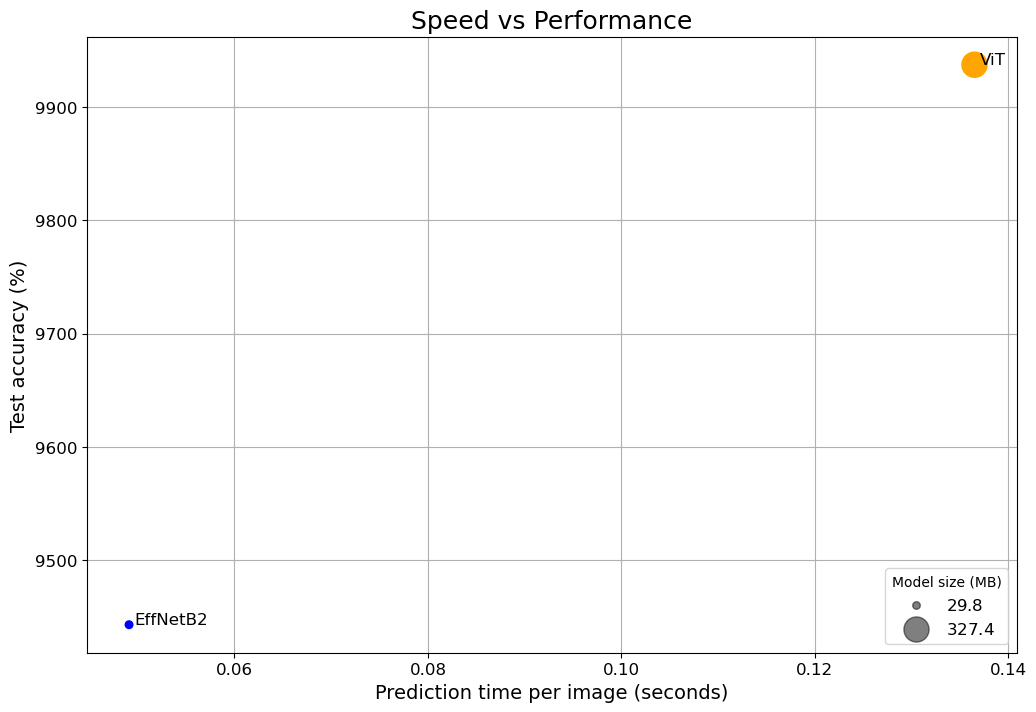

In [44]:
fig, ax = plt.subplots(figsize=(12, 8))
scatter = ax.scatter(data=df, 
                     x="time_per_pred_cpu", 
                     y="test_acc", 
                     c=["blue", "orange"], 
                     s="model_size(Mb)") 

ax.set_title("Speed vs Performance", fontsize=18)
ax.set_xlabel("Prediction time per image (seconds)", fontsize=14)
ax.set_ylabel("Test accuracy (%)", fontsize=14)
ax.tick_params(axis='both', labelsize=12)
ax.grid(True)

for index, row in df.iterrows():
    ax.annotate(text=row["model"], 
                xy=(row["time_per_pred_cpu"]+0.0006, row["test_acc"]+0.03),
                size=12)

handles, labels = scatter.legend_elements(prop="sizes", alpha=0.5)
model_size_legend = ax.legend(handles, 
                              labels, 
                              loc="lower right", 
                              title="Model size (MB)",
                              fontsize=12)

plt.savefig("images/-speed-vs-performance.jpg")

plt.show()

In [ ]:

def predict(img,model,transforms):
    start_time = timer()
    
    img = transforms(img).unsqueeze(0)
    
    model.eval()
    with torch.inference_mode():
        pred_probs = torch.softmax(model(img), dim=1)
    
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}
    
    pred_time = round(timer() - start_time, 5)
    
    return pred_labels_and_probs, pred_time

In [46]:
effnetb2.to("cpu") 

next(iter(effnetb2.parameters())).device

device(type='cpu')

[INFO] Predicting on image at path: data/pizza_steak_sushi_20_percent/test/steak/3553838.jpg

actual:  steak
Prediction label and probability dictionary: 
{'pizza': 0.15273001790046692, 'steak': 0.4967905282974243, 'sushi': 0.3504795730113983}
Prediction time: 0.03974 seconds


Text(0.5, 1.0, 'Actual : steak\nPred : steak(0.497)')

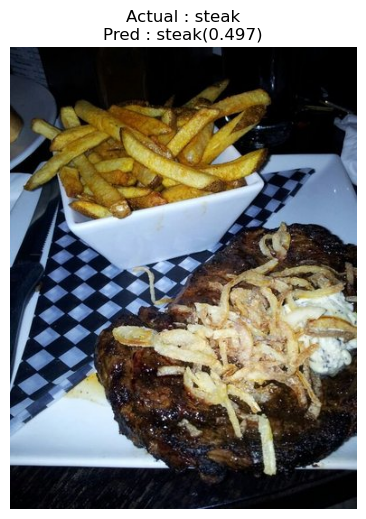

In [ ]:
import random
from PIL import Image

test_data_paths = list(Path(test_dir).glob("*/*.jpg"))

random_image_path = random.sample(test_data_paths, k=1)[0]

image = Image.open(random_image_path)
print(f"[INFO] Predicting on image at path: {random_image_path}\n")

actual = random_image_path.parent.stem
print("actual: ",actual)
pred_dict, pred_time = predict(img=image,model=effnetb2,transforms=effnetb2_transforms)
print(f"Prediction label and probability dictionary: \n{pred_dict}")
print(f"Prediction time: {pred_time} seconds")

plt.figure(figsize=(6,6))
plt.imshow(image)
plt.axis(False)
title_pred = sorted(pred_dict.items(),key=lambda x:x[1])[-1]

title_str = f"Actual : {actual}\n" + f"Pred : {title_pred[0]+'('+str(round(title_pred[1],3))+')'}"


plt.title(title_str)

In [ ]:
# import random
# from PIL import Image

# test_data_paths = list(Path(test_dir).glob("*/*.jpg"))

# random_image_path = random.sample(test_data_paths, k=1)[0]

# image = Image.open(random_image_path)
# print(f"[INFO] Predicting on image at path: {random_image_path}\n")

# actual = random_image_path.parent.stem
# print("actual: ",actual)

# transformed_image = vit_transforms(image)
# transformed_image = transformed_image.permute(1,2,0).unsqueeze(0)
# # print(transformed_image.permute(1,2,0).shape)
# pred_dict, pred_time = predict(img=transformed_image,model=vit)
# print(f"Prediction label and probability dictionary: \n{pred_dict}")
# print(f"Prediction time: {pred_time} seconds")

# plt.figure(figsize=(6,6))
# plt.imshow(image)
# plt.axis(False)
# title_pred = sorted(pred_dict.items(),key=lambda x:x[1])[-1]

# title_str = f"Actual : {actual}\n" + f"Pred : {title_pred[0]+'('+str(round(title_pred[1],3))+')'}"


# plt.title(title_str)